# Задание

**Экономика городов**

Данные описывают экономические условия в 48 городах мира в 1991 году.
Данные были собраны отделом экономических исследований банка Union
(Швейцария). Описаны экономические условия в 48 городах мира в 1991 году.

Число наблюдений: 48

Названия переменных:  
*City (Город)*: Название города  
*Работа (Work)*: Взвешенное среднее числа рабочих часов, сосчитанное по 12
профессиям  
*Цена (Price)*: Индекс цен 112 товаров и услуг, включая арендную плату за
жилье (значение для Цюриха взято за 100%)   
*Заработная плата (Salary)*: Индекс заработной платы за час работы,
сосчитанный по 12 профессиям после налогов и вычетов (значение для Цюриха
взято за 100%)

Требуется выполнить:

Иерархический кластерный анализ
Кластерный анализ методом к-средних (k-means)
Кластерный анализ методом DBSCAN



Определить число кластеров и обосновать свой выбор.

Разбить объекты на кластеры. Предложить и обосновать интерпретацию кластеров.

# Реализация

## Загрузка и обработка данных

### Загрузка и просмотр данных, подключение библиотек

Подключение библиотек

In [105]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn import metrics

Загрузка данных

In [23]:
df = pd.read_csv("Econom_Cities_data.csv", sep=";", decimal=',', index_col='City')
df

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5
Buenos_Aires,1971,56.1,12.5
Cairo,-9999,37.1,-9999.0
Caracas,2041,61.0,10.9
Chicago,1924,73.9,61.9


В целом оценить данные можно и без вывода статистики, так как число наблюдений всего 48, но для большей наглядности выполним следующую команду

In [24]:
df.describe()

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


По статистике кажется, что есть странные значения в столбцах `Work` и `Salary`. Действительно, для городов *Cairo* и *Jakarta* наблюдается отсутствие значений в данных столбцах, которое выражается в виде значения -9999, то есть для этих двух городов известно только значение в столбце `Price`.



При просмотре данных также можно заметить, что значения в столбцах взаимосвязаны, то есть параметры имеют некоторую корреляцию. Это наталкивает на две идеи:

1) Есть смысл использовать факторный анализ (с одной стороны количество параметров и так небольшое, с другой - можно выделить два фактора, которые будут более независимы)

2) Имеет смысл заменить неопределенные значения для двух городов средним значением среди тех городов, которые близки по значению столбца Price.

### Обработка данных

Для начала заменим неопределенные значения.

Предлагаю взять города, которые отличаются по параметру `Price` не более чем на 10% от всего диапазона значений этого параметра.  
Для них посчитаем среднее значение тех параметров, для которых значения в городах пропущено.

In [25]:
price_range = df['Price'].max() - df['Price'].min()

for index, row in df[df['Work'] == -9999].iterrows():
  price_value = row['Price']
  df.loc[index, 'Work'] = df[(df['Price'] >= price_value - 0.1 * price_range) & (df['Price'] <= price_value + 0.1 * price_range) & (df['Work'] != -9999)]['Work'].mean()

for index, row in df[df['Salary'] == -9999.0].iterrows():
  price_value = row['Price']
  df.loc[index, 'Salary'] = df[(df['Price'] >= price_value - 0.1 * price_range) & (df['Price'] <= price_value + 0.1 * price_range) & (df['Salary'] != -9999.0)]['Salary'].mean()

In [26]:
df

,Work,Price,Salary
City,,,
Amsterdam,1714.000000,65.6,49.000000
Athens,1792.000000,53.8,30.400000
Bogota,2152.000000,37.9,11.500000
Bombay,2052.000000,30.3,5.300000
Brussels,1708.000000,73.8,50.500000
Buenos_Aires,1971.000000,56.1,12.500000
Cairo,2063.833333,37.1,6.533333
Caracas,2041.000000,61.0,10.900000
Chicago,1924.000000,73.9,61.900000


In [27]:
df.describe()

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1885.885127,68.860417,38.266377
std,173.233321,21.784659,25.010589
min,1583.000000,30.300000,2.700000
25%,1747.750000,49.650000,12.250000
50%,1862.000000,70.500000,40.300000
75%,1990.739583,81.700000,58.700000
max,2375.000000,115.500000,100.000000


Теперь данные выглядят более естественно.

Следующий шаг - стандартизация параметров.

In [29]:
from sklearn import preprocessing

# Выбираем один из вариантов стандартизации

stand_1 = preprocessing.StandardScaler()

# вычисляем параметры стандартизации (они сохраняются внутри объекта norm)
stand_1.fit(df)
# преобразуем данные
df_scaled = stand_1.transform(df)
# Получаем объект X -- матрицу класса numpy.ndarray.
# Преобразуем её в объект класса pandas.DataFrame.
df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)
df_scaled.head()

,Work,Price,Salary
City,,,
Amsterdam,-1.002717,-0.151250,0.433705
Athens,-0.547693,-0.698647,-0.317850
Bogota,1.552421,-1.436242,-1.081527
Bombay,0.969056,-1.788804,-1.332045
Brussels,-1.037719,0.229145,0.494314


Теперь попробуем применить факторный анализ (метод главных компонент)

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_scaled)
pca.explained_variance_ratio_

array([0.73232106, 0.20666811])

In [31]:
sum(pca.explained_variance_ratio_)

0.9389891651176904

Как мы видим, практически 94% учтено в двух компонентах, что является хорошим результатом, поэтому факторный анализ применим.

In [32]:
pca.components_

array([[-0.49088886,  0.61567415,  0.61641989],
       [ 0.87121294,  0.35015904,  0.34405909]])

Здесь мы можем видеть, что в самый важный фактор входят параметры `Price` и `Salary`, а во втором факторе наибольшее влияние оказывает `Work`.

Получим значения новых компонентов для наблюдений:

In [34]:
upd_df = pca.transform(df_scaled)
upd_df = pd.DataFrame(upd_df, index=df.index, columns=['component_1','component_2'])
upd_df

,component_1,component_2
City,,
Amsterdam,0.666447,-0.777322
Athens,-0.357212,-0.831154
Bogota,-2.312998,0.477467
Bombay,-2.398118,-0.240414
Brussels,0.955189,-0.653764
Buenos_Aires,-1.249958,-0.132901
Cairo,-2.207072,-0.052669
Caracas,-1.350318,0.280215
Chicago,0.623433,0.604132


Так как у нас всего две компоненты, то можно визуализировать данные на плоскости:

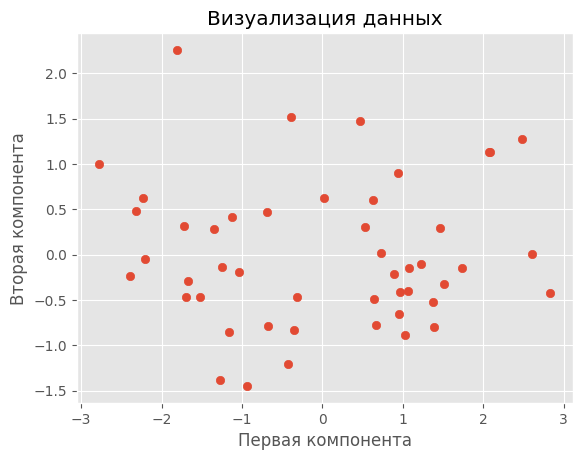

In [36]:
plt.scatter(upd_df['component_1'], upd_df['component_2'])


# for label, component_1, component_2 in zip(upd_df.index, upd_df['component_1'], upd_df['component_2']):
#   plt.annotate(label,
#                xy=(component_1, component_2),
#                xytext=(5,-5),
#                textcoords='offset points')

plt.title("Визуализация данных")
plt.xlabel("Первая компонента")
plt.ylabel("Вторая компонента")
plt.show()

## Иерархический кластерный анализ

In [39]:
#  Активируем 3 процедуры иерархического кластерного анализа

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [66]:
#  кластерный анализ

link = linkage(upd_df, 'ward', 'euclidean')

Построим дендрограмму:

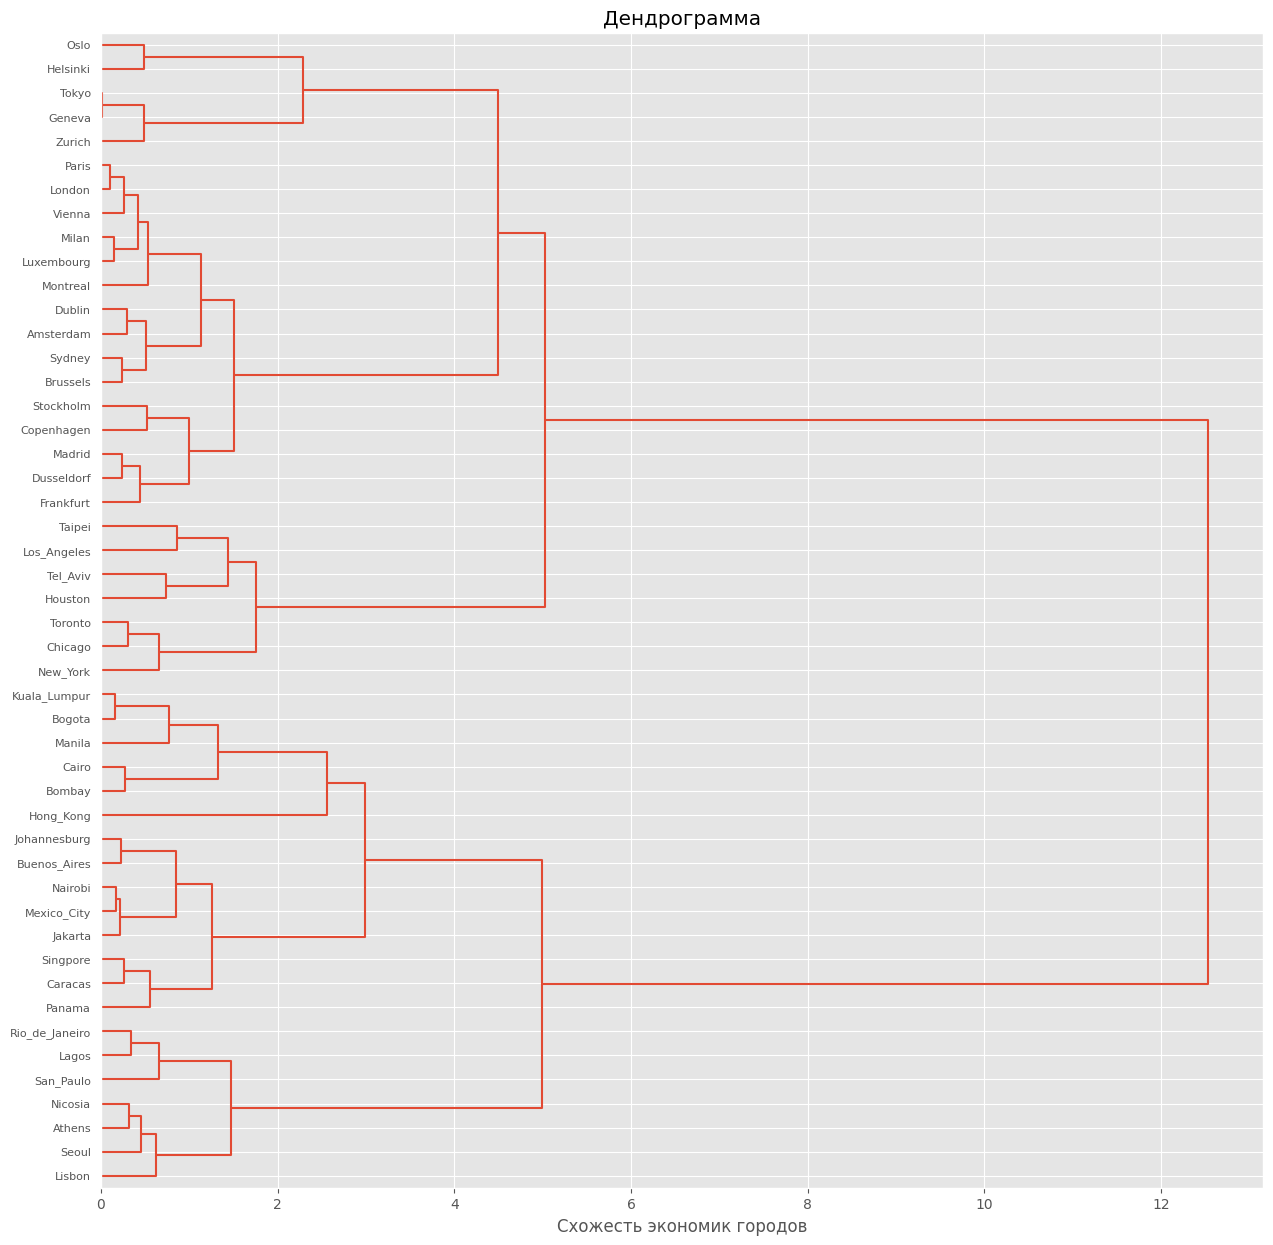

In [67]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(111)
ax1.set_xlabel('Схожесть экономик городов')

ax1.set_title('Дендрограмма')

dn = dendrogram(link,
                # массив с названиями объектов для подписи по оси X
                labels=upd_df.index,
                color_threshold=-1,
                # повернуть подписи вертикально
                orientation = "right",
                leaf_rotation=0.,
                show_leaf_counts=False)

Также построим график "каменистая осыпь", чтобы определить число кластеров наверняка.

Text(0, 0.5, 'Расстояние')

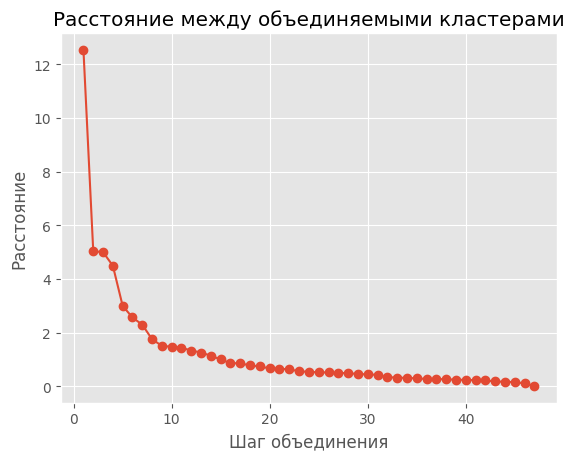

In [68]:
dist = link[:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Расстояние между объединяемыми кластерами')
plt.xlabel('Шаг объединения')
plt.ylabel('Расстояние')

Я бы остановился на варианте с 5-ю кластерами (между шагами 4 и 5) - уже на данном этапе виден скачок в расстоянии при объединении.

Построим дендрограмму в соответствии с таким количеством кластеров:

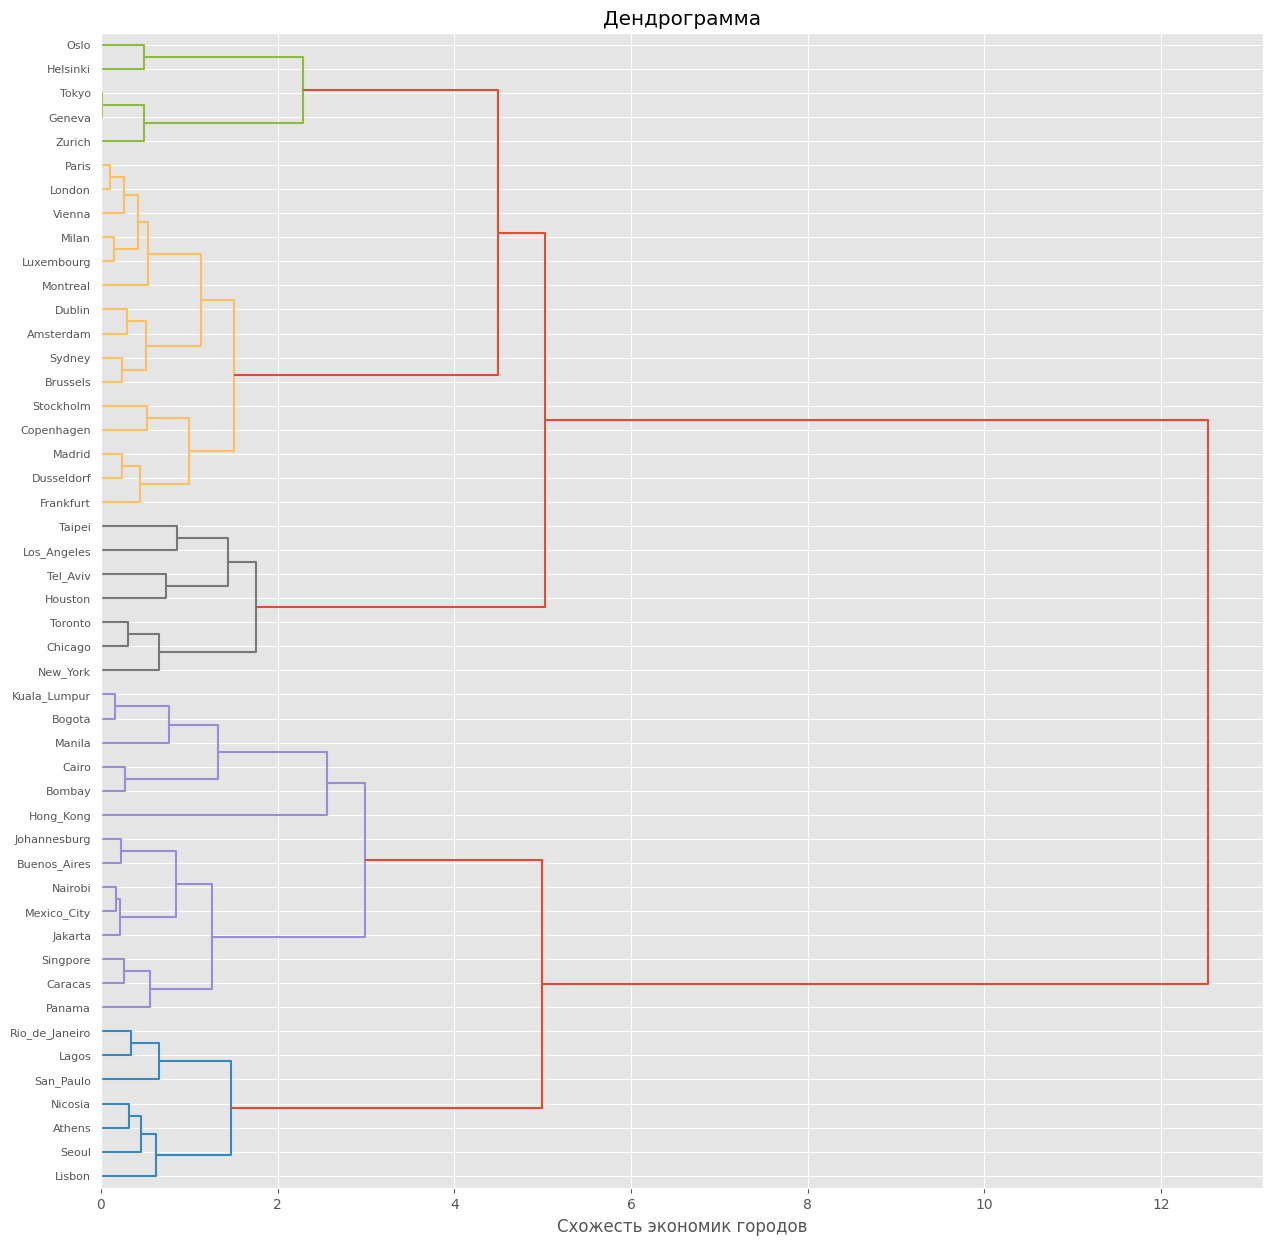

In [70]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(111)
ax1.set_xlabel('Схожесть экономик городов')

ax1.set_title('Дендрограмма')

dn = dendrogram(link,
                # массив с названиями объектов для подписи по оси X
                labels=upd_df.index,
                color_threshold=4,
                # повернуть подписи вертикально
                orientation = "right",
                leaf_rotation=0.,
                show_leaf_counts=False)

Выведем соотношение городов и кластеров

In [76]:
upd_df_1 = pd.DataFrame(upd_df, index=df.index)
upd_df_1['cluster'] = fcluster(link, 4, criterion='distance')
upd_df_1['cluster'].sort_values()

City
Athens            1
Nicosia           1
Rio_de_Janeiro    1
San_Paulo         1
Lisbon            1
Lagos             1
Seoul             1
Hong_Kong         2
Mexico_City       2
Manila            2
Panama            2
Kuala_Lumpur      2
Johannesburg      2
Jakarta           2
Nairobi           2
Caracas           2
Cairo             2
Buenos_Aires      2
Bombay            2
Bogota            2
Singpore          2
New_York          3
Houston           3
Taipei            3
Tel_Aviv          3
Chicago           3
Toronto           3
Los_Angeles       3
Stockholm         4
Sydney            4
Paris             4
Amsterdam         4
Milan             4
Madrid            4
Luxembourg        4
Vienna            4
London            4
Frankfurt         4
Dusseldorf        4
Dublin            4
Copenhagen        4
Brussels          4
Montreal          4
Oslo              5
Helsinki          5
Geneva            5
Tokyo             5
Zurich            5
Name: cluster, dtype: int32

Посчитаем силуэт:

In [107]:
silhouette_avg = metrics.silhouette_score(upd_df, upd_df_1['cluster'])
silhouette_avg

0.570448887449042

Отобразим данные на диаграмме с распределнием по кластерам:

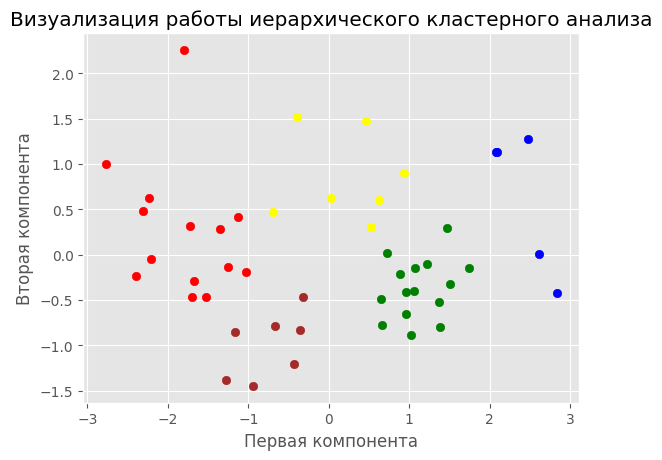

In [81]:
colors = {1: 'brown', 2: 'red', 3: 'yellow', 4: 'green', 5: 'blue'}
for i in range(1, upd_df_1['cluster'].max() + 1):
  plt.scatter(upd_df_1[upd_df_1['cluster'] == i]['component_1'], upd_df_1[upd_df_1['cluster'] == i]['component_2'], c=colors[i])


# for label, component_1, component_2 in zip(upd_df.index, upd_df['component_1'], upd_df['component_2']):
#   plt.annotate(label,
#                xy=(component_1, component_2),
#                xytext=(5,-5),
#                textcoords='offset points')

plt.title("Визуализация работы иерархического кластерного анализа")
plt.xlabel("Первая компонента")
plt.ylabel("Вторая компонента")
plt.show()

## Кластерный анализ методом k-средних

In [78]:
#  Будем использовать процедуру KMeans из библиотеки sklearn

from sklearn.cluster import KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

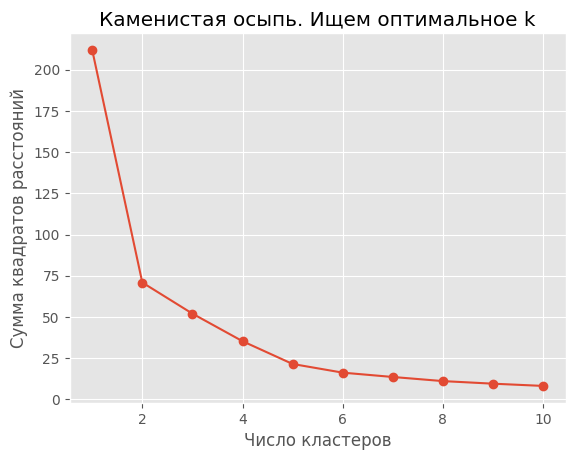

In [79]:
K = range(1, 11)

# Вычисляем значения критерия качества для разного числа кластеров
models = [KMeans(n_clusters=k, random_state=42).fit(upd_df) for k in K]
dist = [model.inertia_ for model in models]

# Строим график каменистая осыпь
plt.plot(K, dist, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Каменистая осыпь. Ищем оптимальное k')
plt.show()

В методе k-средних гиперпараметр - количество кластеров, поэтому я построил график каменистой осыпи с числом кластеров, чтобы наиболее верно определить количество кластеров. Видно, что первый (справа) излом происходит, когда количество кластеров равно 5.

Получим метки кластеров для количества равного 5:

In [85]:
model = KMeans(n_clusters=5, random_state=42).fit(upd_df)

upd_df_2 = pd.DataFrame(upd_df, index=df.index)
upd_df_2['cluster'] = model.labels_
upd_df_2['cluster'].sort_values()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


City
Athens            0
Nicosia           0
Seoul             0
Lagos             0
Lisbon            0
Rio_de_Janeiro    0
San_Paulo         0
Los_Angeles       1
New_York          1
Taipei            1
Chicago           1
Houston           1
Toronto           1
Tel_Aviv          1
Panama            2
Manila            2
Mexico_City       2
Kuala_Lumpur      2
Hong_Kong         2
Jakarta           2
Singpore          2
Caracas           2
Cairo             2
Buenos_Aires      2
Bombay            2
Bogota            2
Johannesburg      2
Nairobi           2
Stockholm         3
Sydney            3
Paris             3
Amsterdam         3
Milan             3
Madrid            3
Luxembourg        3
Vienna            3
London            3
Frankfurt         3
Dusseldorf        3
Dublin            3
Copenhagen        3
Brussels          3
Montreal          3
Oslo              4
Helsinki          4
Geneva            4
Tokyo             4
Zurich            4
Name: cluster, dtype: int32

Посчитаем силуэт:

In [109]:
silhouette_avg = metrics.silhouette_score(upd_df, upd_df_2['cluster'])
silhouette_avg

0.570448887449042

Отобразим данные на диаграмме с распределением по кластерам

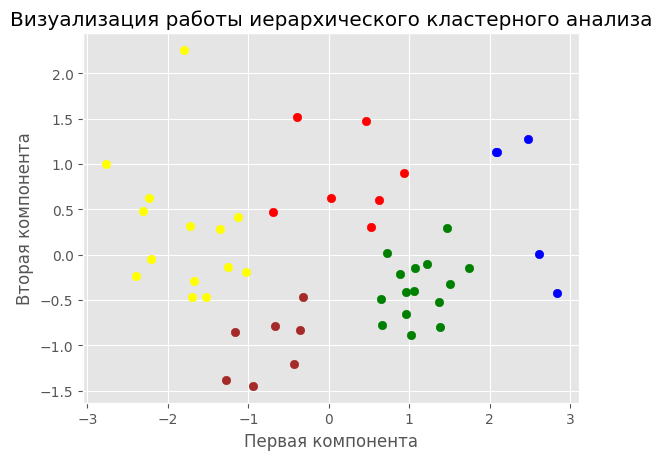

In [86]:
colors = {0: 'brown', 1: 'red', 2: 'yellow', 3: 'green', 4: 'blue'}
for i in range(upd_df_2['cluster'].max() + 1):
  plt.scatter(upd_df_2[upd_df_2['cluster'] == i]['component_1'], upd_df_2[upd_df_2['cluster'] == i]['component_2'], c=colors[i])


# for label, component_1, component_2 in zip(upd_df.index, upd_df['component_1'], upd_df['component_2']):
#   plt.annotate(label,
#                xy=(component_1, component_2),
#                xytext=(5,-5),
#                textcoords='offset points')

plt.title("Визуализация работы иерархического кластерного анализа")
plt.xlabel("Первая компонента")
plt.ylabel("Вторая компонента")
plt.show()

## Кластерный анализ методом DBSCAN

In [104]:
from sklearn.cluster import DBSCAN

Создадим массивы эпсилон и m для перебора параметров в DBSCAN

In [115]:
eps_1 = [0.95, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
min_samples_1 = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [116]:
sil_avg = []

#  Для сохранения наилучшено набора параметров
max_value = [0, 0, 0, -1]

In [117]:
#  Перебираю все пары значений параметров
#  Сохраняю лучшее решение

for i in range(len(eps_1)):
    for j in range(len(min_samples_1)):

        db = DBSCAN(min_samples=min_samples_1[j], eps=eps_1[i]).fit(upd_df)

        labels = db.labels_

        # Число кластеров, после отбрасывания выбросов.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        # Число выбросов.
        # n_noise_ = list(labels).count(-1)

        if n_clusters_ > 1:
            silhouette_avg = metrics.silhouette_score(upd_df, labels)
            if silhouette_avg > max_value[3]:
                max_value=(eps_1[i], min_samples_1[j], n_clusters_, silhouette_avg)
            sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0],
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 0.95 
min_sample= 2 
number of clusters= 6 
average silhouette score= 0.6133


Как мы видим, лучший результат при эпсилон равном 0.95 и m равном 2. Может быть стоит взять эпсилон меньше?

In [118]:
eps_1 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
min_samples_1 = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [119]:
sil_avg = []

#  Для сохранения наилучшено набора параметров
max_value = [0, 0, 0, -1]

In [120]:
#  Перебираю все пары значений параметров
#  Сохраняю лучшее решение

for i in range(len(eps_1)):
    for j in range(len(min_samples_1)):

        db = DBSCAN(min_samples=min_samples_1[j], eps=eps_1[i]).fit(upd_df)

        labels = db.labels_

        # Число кластеров, после отбрасывания выбросов.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        # Число выбросов.
        # n_noise_ = list(labels).count(-1)

        if n_clusters_ > 1:
            silhouette_avg = metrics.silhouette_score(upd_df, labels)
            if silhouette_avg > max_value[3]:
                max_value=(eps_1[i], min_samples_1[j], n_clusters_, silhouette_avg)
            sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0],
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 0.9 
min_sample= 2 
number of clusters= 6 
average silhouette score= 0.6133


Теперь лучший результат при эпсилон равном 0.9. Однако результат силуэта не изменился. В поисках наболее лучшего решения проверим диапазон эпсилон от 0.9 до 0.95

In [121]:
eps_1 = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95]
min_samples_1 = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [122]:
sil_avg = []

#  Для сохранения наилучшено набора параметров
max_value = [0, 0, 0, -1]

In [123]:
#  Перебираю все пары значений параметров
#  Сохраняю лучшее решение

for i in range(len(eps_1)):
    for j in range(len(min_samples_1)):

        db = DBSCAN(min_samples=min_samples_1[j], eps=eps_1[i]).fit(upd_df)

        labels = db.labels_

        # Число кластеров, после отбрасывания выбросов.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        # Число выбросов.
        # n_noise_ = list(labels).count(-1)

        if n_clusters_ > 1:
            silhouette_avg = metrics.silhouette_score(upd_df, labels)
            if silhouette_avg > max_value[3]:
                max_value=(eps_1[i], min_samples_1[j], n_clusters_, silhouette_avg)
            sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0],
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 0.9 
min_sample= 2 
number of clusters= 6 
average silhouette score= 0.6133


Результаты остались те же самые, поэтому спокойно можно принять такие результаты как лучшие.

Посмотрим распределение точек по кластерам

In [124]:
dbscan = DBSCAN(eps=max_value[0], metric='euclidean', min_samples=max_value[1], algorithm= 'brute')

dbscan.fit(upd_df)

unique, counts = np.unique(dbscan.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[-1  1]
 [ 0 15]
 [ 1  7]
 [ 2 13]
 [ 3  7]
 [ 4  3]
 [ 5  2]]


Только одна точка попала в выброс - неплохо для DBSCAN.

Получим метки кластеров для каждого города:

In [125]:
upd_df_3 = pd.DataFrame(upd_df, index=df.index)
upd_df_3['cluster'] = dbscan.labels_
upd_df_3['cluster'].sort_values()

City
Hong_Kong        -1
Amsterdam         0
London            0
Sydney            0
Vienna            0
Luxembourg        0
Frankfurt         0
Dusseldorf        0
Dublin            0
Copenhagen        0
Madrid            0
Milan             0
Montreal          0
Stockholm         0
Brussels          0
Paris             0
Nicosia           1
Rio_de_Janeiro    1
Lisbon            1
Lagos             1
Seoul             1
Athens            1
San_Paulo         1
Johannesburg      2
Bogota            2
Panama            2
Singpore          2
Bombay            2
Buenos_Aires      2
Nairobi           2
Cairo             2
Mexico_City       2
Manila            2
Jakarta           2
Caracas           2
Kuala_Lumpur      2
Toronto           3
Tel_Aviv          3
Taipei            3
Los_Angeles       3
New_York          3
Houston           3
Chicago           3
Geneva            4
Tokyo             4
Zurich            4
Helsinki          5
Oslo              5
Name: cluster, dtype: int64

Отобразим данные на диаграмме с распределением по кластерам:

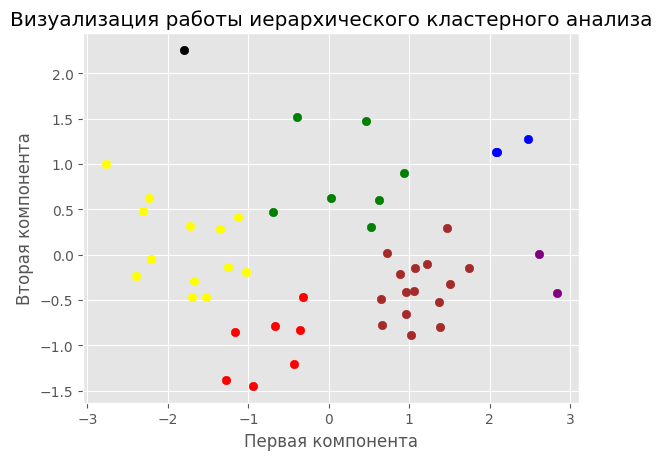

In [126]:
colors = {-1: 'black', 0: 'brown', 1: 'red', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'purple'}
for i in range(-1, upd_df_3['cluster'].max() + 1):
  plt.scatter(upd_df_3[upd_df_3['cluster'] == i]['component_1'], upd_df_3[upd_df_3['cluster'] == i]['component_2'], c=colors[i])


# for label, component_1, component_2 in zip(upd_df.index, upd_df['component_1'], upd_df['component_2']):
#   plt.annotate(label,
#                xy=(component_1, component_2),
#                xytext=(5,-5),
#                textcoords='offset points')

plt.title("Визуализация работы иерархического кластерного анализа")
plt.xlabel("Первая компонента")
plt.ylabel("Вторая компонента")
plt.show()

# Заключение

Произведена кластеризация тремя способами для датасета с экономикой городов.

Иерархический кластерный анализ и кластерный анализ методом k-средних показали одинаковые результаты по количеству кластеров - выделили 5 кластеров.

Кластерный анализ методом DBSCAN выделил 6 кластеров и 1 выброс.

Если сравнивать результаты методов, то Иерархический кластерный анализ и метод k-средних все точки определили в одни и те же кластеры, расхождений не замечено.

В DBSCAN город Hong_Kong посчитался за выброс, а кластеры с городами Geneva, Tokyo, Zurich и Helsinki, Oslo были разделены на два отдельных.

Таким образом различие у DBSCAN произошло только в граничных случаях. Если посмотреть на данные этих городов глазами, то действительно Hong_Kong немного не похож на остальные города из кластера, к которому относили первые два метода. С другой стороны считать этот город выбросом тоже странно. Про разделенный кластер можно сказать, что в целом его можно считать одним кластером, как города с очень высоким уровнем жизни.

Также я бы отметил, что в данной задаче кажутся более удобными первые два метода, так как мы можем управлять количеством кластеров. Перед нами, например, может стоять задача разделить города на те, в которых уровень жизни высок, а в каких низок, то есть в таком случае нам понадобится 2-3 кластера. DBSCAN же не дает такой возможности.

Метрика силуэт отрабатывает неплохо на данном наборе данных, так как здесь нет ленточных кластеров.